In [41]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
import time
from torch.autograd import Variable
from glob import glob
import os
import torch.nn as nn
from torch.optim import lr_scheduler
from torch import optim
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import shutil
from torchvision import transforms
from torchvision import models

In [21]:
path = '..\\data\\dogs-vs-cats\\'
files = glob(os.path.join(path, 'train/*.jpg'))
print(type(files), len(files), files[: 3])
print (f'Total image is {len(files)}')

<class 'list'> 25000 ['..\\data\\dogs-vs-cats\\train\\cat.0.jpg', '..\\data\\dogs-vs-cats\\train\\cat.1.jpg', '..\\data\\dogs-vs-cats\\train\\cat.10.jpg']
Total image is 25000


In [22]:
no_of_images = len(files)
shuffle = np.random.permutation(no_of_images)
print (len(shuffle), shuffle[: 10])

25000 [ 4202 18602  2216  9099 14939 17592   467  6273 24319 19068]


In [26]:
for t in ['train', 'valid']:
    for floder in ['dog\\', 'cat\\']:
        os.mkdir(os.path.join(path, t, floder))

FileExistsError: [WinError 183] 当文件已存在时，无法创建该文件。: '..\\data\\dogs-vs-cats\\train\\dog\\'

In [35]:
print (type(files[0]), files[0])
for i in shuffle[: 2000]:
    folder = files[i].split('\\')[-1].split('.')[0]
    image = files[i].split('\\')[-1]
    print (os.path.join(path, 'valid', folder, image))
    os.rename(files[i], os.path.join(path, 'valid', folder, image))

for i in shuffle[2000: ]:
    folder = files[i].split('\\')[-1].split('.')[0]
    image = files[i].split('\\')[-1]
    os.rename(files[i], os.path.join(path, 'train', folder, image))

<class 'str'> ..\data\dogs-vs-cats\train\cat.0.jpg


In [36]:
files = glob(os.path.join(path, 'train', '*/*.jpg')) + glob(os.path.join(path, 'valid', '*/*.jpg'))
no_of_images = len(files)
shuffle = np.random.permutation(no_of_images)
print (no_of_images)

25000


In [39]:
is_cuda = False
if torch.cuda.is_available():
    is_cuda = True
print (is_cuda)

True


In [44]:
def imshow(inp):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)

simple_transform = transforms.Compose([transforms.Resize((224,224))
                                       ,transforms.ToTensor()
                                       ,transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
train = ImageFolder(os.path.join(path, 'train'),simple_transform)
valid = ImageFolder(os.path.join(path, 'valid'),simple_transform)

{'cat': 0, 'dog': 1}
['cat', 'dog']


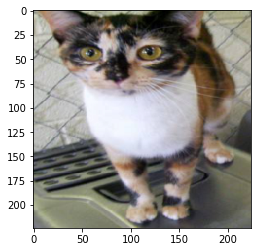

In [53]:
print(train.class_to_idx)
print(train.classes)
imshow(train[4000][0])

In [54]:
train_data_gen = torch.utils.data.DataLoader(train,shuffle=True,batch_size=64,num_workers=3)
valid_data_gen = torch.utils.data.DataLoader(valid,batch_size=64,num_workers=3)

dataset_sizes = {'train':len(train_data_gen.dataset),'valid':len(valid_data_gen.dataset)}

dataloaders = {'train':train_data_gen,'valid':valid_data_gen}


model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

if torch.cuda.is_available():
    model_ft = model_ft.cuda()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to C:\Users\hzp/.torch\models\resnet18-5c106cde.pth
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46827520/46827520 [00:06<00:00, 7798427.46it/s]


In [56]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [57]:
# Loss and Optimizer
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [87]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if torch.cuda.is_available():
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.cpu().numpy() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [88]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.0001 Acc: 0.9995
valid Loss: 0.0004 Acc: 0.9890

Epoch 1/24
----------
train Loss: 0.0001 Acc: 0.9994
valid Loss: 0.0004 Acc: 0.9910

Epoch 2/24
----------


KeyboardInterrupt: 